# AIM
- Preprocess data and match delta_T observation window by PHQ score

# RESULTS
- Replicate Haotian's preprocessing pipeline
- Change pipeline to more appropriate binning procedure

# Setup

In [ ]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import ast

## custom modules
# import sys  
# sys.path.append('../../scripts')

from import_data import *
from clean_data import *
from mappings import *
from plotting import *
from helper import *

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

In [ ]:
import feather

What is this???

In [ ]:
#Link target data and observation data
data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])
data_merge = data_merge.loc[(data_merge.obs_start <= data_merge.date) & (data_merge.date <= data_merge.test_date)]

In [ ]:
#Link target data and observation data
data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])
data_merge = data_merge.loc[(data_merge.obs_start <= data_merge.date) & (data_merge.date <= data_merge.test_date)]

In [ ]:
# Set new ID: old_ID + PHQ time
data_merge["id_new"] = data_merge.id + "_" + data_merge.test_date

# Set new time: date + start_time
data_merge["time"] = data_merge.date+ " " + data_merge.start_time

data_merge = data_merge.drop(["test_date", "obs_start", "start_time"], axis = 1)

In [ ]:
data_merge.to_csv('data_merged.csv',index=0)

In [ ]:
# Set new ID: old_ID + PHQ time
data_merge["id_new"] = data_merge.id + "_" + data_merge.test_date

# Set new time: date + start_time
data_merge["time"] = data_merge.date+ " " + data_merge.start_time

data_merge = data_merge.drop(["test_date", "obs_start", "start_time"], axis = 1)

In [ ]:
data_merge.to_csv('data_merged.csv',index=0)

# Targets
1. import files
2. Preprocessing
    -- Subset by 'clean' PIDs
    * import PID lists
    * subset
    -- Match by date
3. Explore date s
5. Feature extraction
6. Run simple logistic regression model
7. Run empty mixed model vs non-mixed model

# 1. Import

In [ ]:
phqs_raw, slps_raw, metadata = import_data(source_data_dir)

In [ ]:
assert all(phqs_raw.isna().sum() == 0)

# Detour: EDA of PHQ/depr distribution
Aim:    
1. Explore the relationship between PHQ/depr means and SDs
2. Visualize and explore the trajectoires PHQS scores per patients 


In [ ]:
depr_cutoff = 10
dfcp = phqs_raw.copy()
dfcp["depr"] = dfcp["phq"] >= depr_cutoff
pid_depr_pc = (
    dfcp[["pid", "phq", "depr"]]
    .groupby(["pid"])
    .agg(["mean", "std", "count"])
    .pipe(flatten_multiindex, join_by="_")
    .sort_values("depr_mean")
)

In [ ]:
import seaborn as sns

f = sns.scatterplot(
    data=pid_depr_pc, 
    x="phq_mean", 
    y="phq_std", 
    hue="phq_count", 
    size="phq_count",
    sizes=(20, 200)
    # hue_norm=(0, 7), 
    # legend="full"
).set(title='Scatter of PHQ s.d. against PHQ mean, each point is one patient');
plt.show()

sns.scatterplot(
    data=pid_depr_pc, 
    x="depr_mean", 
    y="phq_std", 
    hue="phq_count", 
    size="phq_count",
    sizes=(20, 200), 
    # hue_norm=(0, 7), 
    # legend="full"
).set(title='Scatter of PHQ s.d. against depr mean, each point is one patient');
plt.show()


In [ ]:
g = sns.pairplot(pid_depr_pc)
g.fig.suptitle('Pairplot of depr/phq sd/mean/count',y=1.02);

# Cleaning: Subset by 'clean' PIDs

In [ ]:
pid_phq = set(phqs_raw['pid'])
pid_slp = set(slps_raw['pid'])
pid_meta = set(metadata['subject_id'])

In [ ]:
pid_both = pid_phq.intersection(pid_slp)
pid_three = pid_phq.intersection(pid_slp).intersection(pid_meta)

print(f'{len(pid_phq)=}')
print(f'{len(pid_slp)=}')
print(f'{len(pid_both)=}')
print(f'{len(pid_three)=}')

from matplotlib_venn import venn3_unweighted
venn3_unweighted([pid_phq, pid_slp, pid_meta], set_labels=('PHQ','sleep','meta'));

Import 'allowlist' of PIDs without sleep stage duplication issue

In [ ]:
with open(clean_data_dir/'pid_without_dup.txt','r') as f:
   pid_without_dup = ast.literal_eval(f.read())
# pid_allowlist = pid_without_dup.intersection(pid_both)
# print(f'{len(pid_allowlist)=}')

final filter

In [ ]:
hours_recorded = sum(slps_raw['duration']) / 3600
print(f'Hours recorded: {hours_recorded}')

In [ ]:
# filter phqs
phqs = phqs_raw.copy().loc[ phqs_raw['pid'].isin(pid_three)]
report_n_dropped_rows(phqs_raw, phqs)

# filter slps
slps = slps_raw.copy().loc[ slps_raw['pid'].isin(pid_three)]
report_n_dropped_rows(slps_raw, slps)

# Cleaning: PHQS date formatting

In [ ]:
phqs['time'] = pd.to_datetime(phqs['time'])
phqs['dayofweek'] = phqs['time'].apply(dt.date.isoweekday)

- PHQ observations are not made 14 days apart

In [ ]:
phqs.groupby(['pid','dayofweek']).size().reset_index(name='count')

# EDA: phq trajectories

In [ ]:
centres = set(phqs['centre'])

PLOT_TO_FILE = False

for centre in centres:
    filename = f'phqs_trajectories_{centre}.png'
    outfile = viz_dir/filename
    subset = phqs.loc[phqs['centre']==centre]
    if PLOT_TO_FILE:
        plot_phq_trajectories(df=subset, outfile=outfile)

# 4. Preprocess

## 4.1 Method 1: Haotian's script

In [ ]:
def filter_by_subj_id_existing_in_three_sources(df, tgt, metadata, left_on=['patient id']):
    """
    these steps are the same as filtering by pid that exist in (i) id_list, from metadata (ii) PHQ test records and (iii) sleep stage records
    """

    
    id_list = metadata.loc[:,"subject_id"]
    df = pd.merge(df,id_list,how='inner',left_on=left_on, right_on = ["subject_id"])
    tgt = pd.merge(tgt,id_list,how='inner',left_on=left_on, right_on = ["subject_id"])
    uni = pd.merge(df,tgt,how='inner',on = ["subject_id"])

    n_subjects = len(uni.value_counts('subject_id'))
    print(f'{n_subjects=}')

    # dataset = uni.loc[:,["subject_id", "time stamp_x", "stages", "duration"]].rename(columns={'subject_id':'id'}).drop_duplicates()
    dataset = uni.loc[:,["subject_id", "time_x", "stages", "duration"]].rename(columns={'subject_id':'id'}).drop_duplicates()

    # target = uni.loc[:,["subject_id", "time stamp_y", "phq score"]].rename(columns={'subject_id':'id',"phq score": "phq_score"}).drop_duplicates()
    target = uni.loc[:,["subject_id", "time_y", "phq"]].rename(columns={'subject_id':'id'}).drop_duplicates()
   
    return dataset, target


dataset, target = filter_by_subj_id_existing_in_three_sources(slps, phqs, metadata, left_on=['pid'])
dataset_backup = dataset.copy()
target_backup = target.copy()

In [ ]:
print(f'''
    {dataset.shape=},
    {slps.shape=},
    {target.shape=},
    {phqs.shape=}
''')

print(f'''
    {slps.columns=},
    {dataset.columns=},
    {phqs.columns=},
    {target.columns=}
''')

In [ ]:
# Type "UNKNOWN" have the same meaning with "AWAKE"
# before
print(dataset.value_counts('stages', normalize=True))
# clean
dataset.loc[dataset.stages == "UNKNOWN", 'stages'] = "AWAKE"
print(dataset.value_counts("stages", normalize=True))

In [ ]:
#Split time from date
dataset["date"] = dataset["time_x"].map(lambda x: x[:10])
dataset["start_time"] = dataset["time_x"].map(lambda x: str(x[11:13]))
#Rrans second to hour
dataset["duration_hour"] = dataset["duration"].map(lambda x: x/60/60)

In [ ]:
#Constrain the sleeping start time from 8PM to 10AM
dataset_select = dataset.loc[(pd.to_numeric(dataset["start_time"]) >= 20) | (pd.to_numeric(dataset["start_time"]) <= 10)]
dataset_select = dataset_select.drop(["time_x", "duration"], axis=1)

In [ ]:
#Fill in missing values through format transfer
data_trans_t = dataset_select.pivot_table(index=["id","date","stages"], columns=["start_time"], values=["duration_hour"], fill_value = 0)
data_trans_t.columns = data_trans_t.columns.droplevel(0)
data_trans_t = data_trans_t.reset_index()
#Restore the table
data_trans_t = data_trans_t.melt(
    id_vars=["id","date","stages"],value_name="duration_hour", 
    value_vars=["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "20", "21", "22", "23"]
    ).sort_values(["id","date"])
#Trans the format from wide to Long
data_trans = data_trans_t.pivot_table(index=["id","date","start_time"], columns=["stages"], values=["duration_hour"], fill_value = 0)
#Retain all data to two decimal places
data_trans = round(data_trans, 2)
#Reindex the table
data_trans.columns = data_trans.columns.droplevel(0)
data_tab = data_trans.reset_index()
data_tab.columns.name = None

In [ ]:
data_tab['total'] = data_tab[['AWAKE','DEEP','LIGHT','REM']].sum(axis=1)

In [ ]:
p = clean_data_dir / 'data_tab.ftr'
data_tab.reset_index().to_feather(p)

# Method 2: using time series

In [ ]:
intervals = clean_slps(slps)

In [ ]:
print(dt.datetime.now())
timeseries = explode2ts(intervals, time='t',multiprocessing=False)

print(dt.datetime.now())
timeseries_select = (timeseries
    .set_index('t', inplace=False)
    .between_time('20:00', '10:00')
    .reset_index(inplace=False)
)
report_change_in_nrow(timeseries, timeseries_select)

print(dt.datetime.now())
m = pd.merge(timeseries_select, intervals, left_on='intervalID', right_on='intervalID', how='left')

print(dt.datetime.now())
dedupped = dedup_timeseries(m)

print(dt.datetime.now())
binned = bin_by_hour(dedupped)

print(dt.datetime.now())

In [ ]:
p = clean_data_dir / 'slps_timeseries.ftr'
timeseries.reset_index(drop=True).to_feather(p)

p = clean_data_dir / 'slps_dedupped.ftr'
dedupped.reset_index(drop=True).to_feather(p)

p = clean_data_dir / 'binned.ftr'
binned.reset_index(drop=True).to_feather(p)

In [267]:
from clean_data import *
from helper import *

p = clean_data_dir / 'binned.ftr'
binned = pd.read_feather(p)

binned_norm = normalize_binned(binned)
expanded = expand_full_hours(binned_norm)
report_change_in_nrow(binned_norm, expanded)

expanded.columns = ['id', 'date', 'start_time', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total']

p = clean_data_dir / 'expanded.ftr'
expanded.reset_index(drop=True).to_feather(p)

# :
657489->1171860 rows (Change = 514371) (nrow after = 178.23% of before)


Visualize distribution of hours

In [ ]:
hours = [20,21,22,23,0,1,2,3,4,5,6,7,8,9,10]

hourly_sums = binned.groupby('hour').sum()
# hourly_sums_pc = hourly_sums / hourly_sums.sum()
# hourly_sums_pc = round(hourly_sums_pc*100, 2)

hourly_sums = hourly_sums.reindex(hours)
hourly_sums.plot.bar();

There is still problem, hourly sum can be over 120
(supposingly 120 intervals in one hour, each 30-seconds)

In [ ]:
binned.loc[binned['sum']>120]

## Troubleshooting (ongoing)

In [ ]:
m.head(3)

In [ ]:
pid_q = '0104dfff-4dcd-48ff-b912-51362f098ed0'
date_q = dt.date(2019,5,24)

m_q = m.loc[(m['pid']==pid_q) & (m['start_date']==date_q), :]
m_q


In [ ]:
dedupped_q = dedupped.loc[(dedupped['pid']==pid_q), :]
dedupped_q = dedupped_q.loc[(dedupped_q['start_date']==date_q),:]
dedupped_q

In [ ]:
dedupped_q['start'].dt.hour.value_counts()

In [ ]:
m_q['start'].dt.hour.value_counts()

In [ ]:
intv_q = subset_intervals(intervals, start_date=date_q, end_date=date_q, id=pid_q)
plot_gannt(intv_q, metadata);

# Gannt chart visualization

In [ ]:
from plotting import *

plotdf = subset_intervals(
    intervals, 
    start_date=dt.date(2019, 4, 13), end_date=dt.date(2019, 4, 15), 
    id = "007751c5-d7ad-4bec-a58f-abf32500e2ae"
)

plot_gannts(plotdf, metadata)

# Original script is troublesome

In [2]:
print((data_tab['total'] > 1).value_counts(normalize=True))
data_tab['total'].plot.hist(bins=100);

NameError: name 'clean_data_dir' is not defined

<AxesSubplot:ylabel='Frequency'>

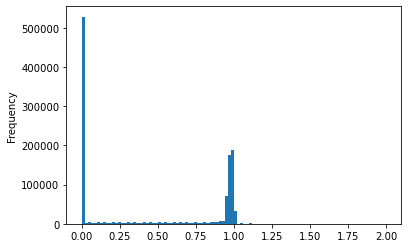

In [265]:
expanded['total'].plot.hist(bins=100)

Clean target

In [236]:
#Clean target data
"""target["test_date"] = target["time_y"].map(lambda x: x[:10])"""
#! replaced by:
target["test_date"] = target['time_y'].dt.date
target_new = target.loc[:,["id", "test_date", "phq"]]

#Get observation start and end times
"""
id_obs_start = data_tab.groupby('id')['date'].min()
id_obs_end = data_tab.groupby('id')['date'].max()
"""

#! replaced by
expanded.columns = ['id', 'date', 'start_time', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total']
id_obs_start = expanded.groupby('id')['date'].min()
id_obs_end = expanded.groupby('id')['date'].max()

In [237]:

#Adjust the time format
target_new["obs_start"] = pd.to_datetime(target_new.test_date) - pd.Timedelta(days=15)
target_new["obs_start"] = target_new["obs_start"].apply(lambda x:x.strftime('%Y-%m-%d'))

In [238]:
target_new

,id,test_date,phq,obs_start
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-02-04,17.0,2019-01-20
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-04,22.0,2019-02-17
3,bf3defd7-2a52-4557-8202-9d887957e109,2019-03-18,19.0,2019-03-03
4,bf3defd7-2a52-4557-8202-9d887957e109,2019-04-01,14.0,2019-03-17
...,...,...,...,...
26740932,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-11-06,19.0,2019-10-22
26740933,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-11-20,13.0,2019-11-05
26740934,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-12-04,18.0,2019-11-19
26740935,09828ab7-192f-4aab-88d5-eb1f5891e367,2019-12-18,21.0,2019-12-03


In [239]:
#Join the tables
target_new = target_new.merge(id_obs_start, on="id", how="left").merge(id_obs_end, on="id", how="left")

#Filter the target data during the observation period
target_select = target_new.loc[
    (pd.to_datetime(target_new['test_date']) >= pd.to_datetime(target_new['date_x'])) & 
    (pd.to_datetime(target_new['obs_start']) <= pd.to_datetime(target_new['date_y']))
]
#Drop extra columns
target_select = target_select.drop(["date_x", "date_y"], axis = 1)


In [240]:
from clean_data import *
from helper import *
target_select = drop_days_delta(target_select)

# Drop PHQ records which is <14 days from previous:
4283->4074 rows (Change:-209, 95.12% of original)


In [245]:
#Link target data and observation data
"""data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])"""
#! replaced by
data_merge = pd.merge(target_select, expanded, how='outer', on=['id'])

In [243]:
data_merge.head(3)

,id,test_date,phq,obs_start,date,start_time,AWAKE,DEEP,LIGHT,REM,total
0,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,20,0.0,0.0,0.0,0.0,0.0
1,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,21,0.0,0.0,0.0,0.0,0.0
2,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21,16.0,2019-01-06,2019-01-21,22,0.1,0.0,0.0,0.0,0.1


In [246]:
data_merge_select = data_merge.loc[(pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date)) & (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))]
report_change_in_nrow(data_merge, data_merge_select)
data_merge = data_merge_select.copy()

# :
15828720->735555 rows (Change:-15093165, 4.65% of original)


In [247]:
# Set new ID: old_ID + PHQ time
#! updated
data_merge["id_new"] = data_merge.id + "_" + data_merge.test_date.astype("string")

In [249]:
# Set new time: date + start_time
#! updated
data_merge["time"] = data_merge.date.astype("string") + " " + data_merge.start_time.astype("string")

In [250]:
data_merge = data_merge.drop(["test_date", "obs_start", "start_time"], axis = 1)

In [252]:
show = data_merge.head(1000)

Export

In [254]:
p1 = clean_data_dir/'data_merge.csv'
p2 = clean_data_dir/'data_merge.ftr'
data_merge.to_csv(p1,index=0)
data_merge.reset_index().to_feather(p2)

In [260]:
print(expanded.shape, data_merge.shape)


(1171860, 8) (735555, 10)


In [257]:
data_merge.columns

Index(['id', 'phq', 'date', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total', 'id_new',
       'time'],
      dtype='object')

In [256]:
print(f"""
Shape = {data_merge.shape},
{data_merge["id']}
"""
)



Shape = (735555, 10),


